<a href="https://colab.research.google.com/github/Neighborc/tlabTutorials/blob/master/Reservoir_MNIST_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import time
import os

## Reservoir
Here I give a walkthrough of how to use PyTorch for constructing a reservoir, essentially a randomized recurrent neural network, for classification. A more in-depth implementation which could be good for reference is [EchoTorch](https://github.com/nschaetti/EchoTorch)

The main steps I use are to initialize a RNN with standard nodes, replace the weight matrix only the readout layer is trained. 

There are many other parameters to tune.

In [0]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as utils


# set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

First in order to use PyTorch effectively we want to it up to use the availabe GPU device

In [3]:
# Setup the ability to run on a GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


## Constructing the reservoir 
Here we create a recurrent neural network, set its internal weights according to the Echo State Property and then freeze all the weights except the output. 
Additionally aother simple way of doing this is by removing the final layer and running the data through the reservoir and then training a classifier on these node output values. 

In [0]:
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F
import torch.optim as optim

class RNN(nn.Module):
    def __init__(self, input_size, n_hidden, num_layers, num_classes, sequence_length, dropout=0, return_sequence=False):
        super(RNN, self).__init__()
        self.n_hidden = n_hidden
        self.sequence_length = sequence_length
        self.num_layers = num_layers
        self.return_sequence = return_sequence
          
        self.hidden = nn.RNN(input_size, n_hidden, num_layers, batch_first=True, bias=False)
        self.drop_layer = nn.Dropout(p=dropout)
        if return_sequence:
          self.fc = nn.Linear(n_hidden*sequence_length, num_classes)
        else:
          self.fc = nn.Linear(n_hidden, num_classes)
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.n_hidden).to(device) 
        
        # Forward propagate
        out, h_n = self.hidden(x, h0)  # out: tensor of shape (batch_size, seq_length, n_hidden)
        if self.return_sequence:
          out = out.contiguous().view(-1,self.n_hidden*self.sequence_length)
          out = self.fc(out)
        else:
          out = self.fc(out[:,-1,:])
        return out

def create_reservoir_matrix(size=(10,10), spectral_radius=0.9, sparsity=0.5):
    """ Creates the W_res of the ESN which has the ESP
    inputs: 
    size: square matrix representing the size of teh reservoir connections
    spectral_radius: largest eigenvalue in reservoir matrix should be <1
    sparsity: connectivity of matrix, 1.0 indicates full connection 
    """
    # generate uniformly random from U[0,1] *2 -1 makes it U[-1,1]
    W_res = torch.rand(size)*2-1

    # create a sparse mask array then multiply reservoir weights by sparse mask
    # sparse mask is done by generating uniform[0,1] then setting True <=sparsity
    W_res = W_res*(torch.rand_like(W_res) <= sparsity).type(W_res.dtype)
    
    # scale the matrix to have the desired spectral radius
    W_res = W_res*spectral_radius/(np.max(np.abs(np.linalg.eigvals(W_res))))

    return W_res


from numpy import linalg as LA
from scipy.sparse import random as sparserand
def create_sparse_connection_matrix(size=(10,10),spectral_radius=0.9, sparsity=0.5):
  """ Creates a sparse matrix using a different library which is not probabilistic
  and so should have a better consistancy for small networks 
  returns a numpy array"""
  matrix = sparserand(size[0],size[1], density=sparsity)
  matrix = matrix.A*2-1 # shift from U[0,1] to U[-1,1]

  max_eigval = max(abs(LA.eigvals(matrix.A)))
  if max_eigval == 0:
    # checks for an entirely sparse matrix
    return matrix.A

  else:
    matrix = spectral_radius*matrix.A/max_eigval
    return matrix


### MNIST Example

Load in the MNIST data, transform it, and build some batched dataloaders

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dsets
import torchvision.transforms as transforms


In [0]:
# set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Hyper Parameters 
input_size = (28, 28)
num_classes = 10
num_epochs = 10
batch_size_train = 64
batch_size_test = 1024
learning_rate = 1e-3

In [11]:
train_dataset = dsets.MNIST(root='./data', train=True, 
                            transform=transforms.Compose([
                            transforms.Resize(input_size),
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))]),
                            download=True)
test_dataset = dsets.MNIST('./data', train=False,transform=transforms.Compose([
                            transforms.Resize(input_size),
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))]), download=True)

0it [00:00, ?it/s]

9920512it [00:01, 8520095.84it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 128866.50it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


1654784it [00:00, 2014664.75it/s]                            
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


8192it [00:00, 49779.77it/s]            


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [12]:
# check the imported dataset shape
print(train_dataset[0][0].shape)

torch.Size([1, 28, 28])


In [0]:
# Dataset loaders (handle mini-batching of data)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size_train, shuffle=True) 
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size_test, shuffle=False)

In [0]:
def epoch_accuracy(loader, total_size, split='train'):
    """Measure the accuracy for the entire dataset""" 
    
    #set PyTorch model in eval mode for faster inference, no grads passed
    model.eval()

    correct = 0
    total = 0
    for sequences, labels in loader:
        sequences = sequences.view(-1,28,28)
        sequences = sequences.to(device)
        labels = labels.to(device)
        outputs = model(sequences) 
        _, predicted = torch.max(outputs.data, 1) 
        total += labels.size(0) 
        correct += (predicted == labels).sum()

    print(f'Accuracy of the model on the {total_size} {split} sequences: {float(correct) / total:3.1%}')
    
    return float(correct) / total    

At this point we can go through the steps to make the Echo State Network. 
1. Initialize an RNN
2. Create the $W_{res}$ we want for our ESN in the shape of the RNN
3. Replace the hidden weights with $W_{res}$
4. Set the requires_grad to False for the hidden layer, this freezes the layer weights in place and doesn't pass any gradient to the layers before this one as well

You could make the class automatically construct the reservoir as well if you like, using potentially a classmethod

In [0]:
# input parameters
sequence_length = 28
input_size = 28
num_classes = 10

# Hyper-parameters
n_hidden = 50
num_layers = 1 # only works with 1 for now 
batch_size = batch_size_train
learning_rate = 0.001
dropout = 0.05

# create the internal weight matrix
W_res = create_reservoir_matrix(size=(n_hidden, n_hidden), spectral_radius=0.9, sparsity=1.0)

model = RNN(input_size, n_hidden, num_layers, num_classes, 
                  sequence_length=sequence_length, dropout=dropout, return_sequence=True)

# set the internal hidden weight matrix as the reservoir values 
model.hidden.weight_hh_l0 = nn.Parameter(W_res, requires_grad=False)
input_scale = 0.5
model.hidden.weight_ih_l0 = nn.Parameter((torch.rand((n_hidden,input_size))*2-1)*input_scale, requires_grad=False)

# move to the GPU
model.to(device)

# Freeze all hidden layers so no gradient update occurs
for param in model.hidden.parameters():
    param.requires_grad = False

# only need the gradient for the fully connected layer, weight_decay adds l2 norm
optimizer = torch.optim.Adam(model.fc.parameters(), lr=learning_rate, weight_decay=0)

# CrossEntropyLoss takes care of the Softmax evaluation 
criterion = nn.CrossEntropyLoss()

### Train the model 
Here we train the model and keep track of the train and test losses. Note if you rerun this cell the model will continue to train from it's previous state. 

Note this can take around 5 minutes on a CPU, much faster if you run it on a GPU.

Epoch: [1/15], Step: [70/937], Loss: 0.38344958424568176
Epoch: [1/15], Step: [140/937], Loss: 0.4095509648323059
Epoch: [1/15], Step: [210/937], Loss: 0.5083675384521484
Epoch: [1/15], Step: [280/937], Loss: 0.22053581476211548
Epoch: [1/15], Step: [350/937], Loss: 0.3118206262588501
Epoch: [1/15], Step: [420/937], Loss: 0.337104856967926
Epoch: [1/15], Step: [490/937], Loss: 0.29958271980285645
Epoch: [1/15], Step: [560/937], Loss: 0.28666114807128906
Epoch: [1/15], Step: [630/937], Loss: 0.14635005593299866
Epoch: [1/15], Step: [700/937], Loss: 0.11091510206460953
Epoch: [1/15], Step: [770/937], Loss: 0.31741881370544434
Epoch: [1/15], Step: [840/937], Loss: 0.16884376108646393
Epoch: [1/15], Step: [910/937], Loss: 0.24079939723014832
Accuracy of the model on the 10000 test sequences: 93.1%
Accuracy of the model on the 60000 train sequences: 93.2%
Epoch: [2/15], Step: [70/937], Loss: 0.3867510259151459
Epoch: [2/15], Step: [140/937], Loss: 0.3512437045574188
Epoch: [2/15], Step: [21

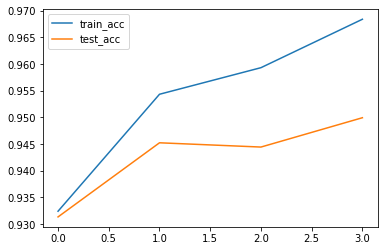

In [18]:
train_acc = []
test_acc = []

num_epochs = 15
for epoch in range(num_epochs):
    for i, (sequences, labels) in enumerate(train_loader):
        # reshape to (batch_size, time_step, input size)
        sequences = sequences.view(-1,28,28)
        sequences = sequences.to(device)
        labels = labels.to(device)
        
        # Forward pass
        optimizer.zero_grad() 
        outputs = model(sequences) 
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        
        # Optimize
        optimizer.step()
        
        # print out your accuracy along the way
        if (i + 1) % 70 == 0:
            print(f'Epoch: [{epoch+1}/{num_epochs}], Step: [{i+1}/{len(train_dataset)//batch_size}], Loss: {loss.item():3}') 
    
    
    # records accuracy on first epoch and on the 5th ones after that
    if epoch==0 or (epoch+1)%5==0:
        test_acc_epoch = epoch_accuracy(test_loader, len(test_dataset), 'test')
        test_acc.append(test_acc_epoch)
        train_acc_epoch = epoch_accuracy(train_loader, len(train_dataset), 'train')
        train_acc.append(train_acc_epoch)

plt.plot(train_acc)
plt.plot(test_acc)
plt.legend(['train_acc','test_acc'])

Note the difference between training and test accuracy. Some form of regularization should be used to improve the generalization of the model. 
Examples of regularization to explore include dropout, l1-norm, and l2-norm. 

## Keras Example
In this case I also demonstrate an example using the Keras library and in this one I demonstrate the method of running the samples through the reservoir and then classifying using a separate model as a readout layer

In [19]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, SimpleRNN, Flatten
from keras import initializers
from keras.models import model_from_json

from keras import optimizers
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [20]:
num_classes = 10
img_rows, img_cols = 28, 28
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# some data preprocessing and normalizing

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

11493376/11490434 [==============================] - 1s 0us/step


In [0]:
from numpy.random import seed
from tensorflow import set_random_seed
from keras import regularizers
  
# for reproducibility
set_seed = 0
seed(set_seed)
set_random_seed(set_seed)

n_hidden = 50
epochs = 15
batch_size = 64
bias_initializer = 'zeros'
dropout = 0.0
# this returns all of the reservoir output values when set to True
return_sequences = True

l1 = 0
l2 = 0

INPUT_SIZE = (x_train.shape[1], x_train.shape[2])

# network is initialized with specific weights and is then only trained
model = Sequential()
model.add(SimpleRNN(n_hidden, activation='tanh', 
                    kernel_initializer=initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=set_seed),
                    bias_initializer=bias_initializer,
                    input_shape=INPUT_SIZE,
                    return_sequences=return_sequences,
                    unroll=False, stateful=False))

# In order for the reservoir to have Echo State property the 
# spectral should be <1
spectral_radius = 0.9
sparsity = 1.0

# gets the weights from the model and generates an effective recurrent weight layer
rnn_weights = model.get_weights()
esn_recurrent_weights = create_reservoir_matrix(size=rnn_weights[1].shape,
                                                  spectral_radius=spectral_radius,
                                                  sparsity=sparsity)
# assigns the new weights for the recurrent layer to the model and keeps input
# weights the same
rnn_weights[1] = esn_recurrent_weights
model.set_weights(rnn_weights)


Now after building the model and replacing the weights, we can run the inputs through the network and save the output values from each of the reservoir nodes.

In [33]:

# propagate through all the inputs and return final output of cells
reservoir_states_train = model.predict(x_train, batch_size=int(len(x_train)/16), verbose=1)
reservoir_states_test = model.predict(x_test, batch_size=int(len(x_test)/16), verbose=1)
  
print(final_state_train.shape)

10000/10000 [==============================] - 0s 30us/step
(60000, 28, 50)


### Final readout layer
Here we can use another network to be the readout layer. There are other libraries which can be useful here as well such as with 

In [34]:
# create the final readout layer, this uses logistic regression

model_final_layer=Sequential()
# converts the sequence of reservoir outputs to a 1D matrix
if return_sequences:
  model_final_layer.add(Flatten())
model_final_layer.add(Dropout(dropout)) 
model_final_layer.add(Dense(num_classes, activation='softmax',
                            activity_regularizer=regularizers.l1_l2(l1=l1, l2=l2)))
                      
# set the learning rate and optimizer with some early stopping
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
earlystopper = EarlyStopping(monitor='val_acc', patience=10, verbose=1)

model_final_layer.compile(loss='categorical_crossentropy',
                          optimizer=adam,
                          metrics=['accuracy'])

history = model_final_layer.fit(reservoir_states_train, y_train, epochs=epochs, 
                      batch_size=batch_size, 
                      validation_data=(reservoir_states_test, y_test), verbose=2, 
                      shuffle=True, callbacks=[earlystopper])


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 60000 samples, validate on 10000 samples
Epoch 1/15
 - 4s - loss: 0.4397 - acc: 0.8719 - val_loss: 0.2965 - val_acc: 0.9129
Epoch 2/15
 - 3s - loss: 0.2943 - acc: 0.9143 - val_loss: 0.2564 - val_acc: 0.9238
Epoch 3/15
 - 3s - loss: 0.2674 - acc: 0.9220 - val_loss: 0.2412 - val_acc: 0.9289
Epoch 4/15
 - 3s - loss: 0.2520 - acc: 0.9270 - val_loss: 0.2328 - val_acc: 0.9298
Epoch 5/15
 - 3s - loss: 0.2401 - acc: 0.9300 - val_loss: 0.2309 - val_acc: 0.9327
Epoch 6/15
 - 3s - loss: 0.2321 - acc: 0.9323 - val_loss: 0.2152 - val_acc: 0.9350
Epoch 7/15
 - 3s - loss: 0.2252 - acc: 0.9339 - val_loss: 0.2138 - val_acc: 0.9339
Epoch 8/15
 - 3s - loss: 0.2202 - acc: 0.9359 - val_loss: 0.2061 - val_acc: 0.9355
Epoch 9/15
 - 3s - loss: 0.2170 - acc: 0.9365 - val_loss: 0.2073 - val_acc: 0.9364
Epoch 10/15
 - 3s - loss: 0.2138 - acc: 0.9372 - val_loss: 0.2026 - val_acc: 0.9387
Epo

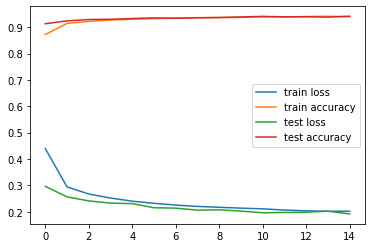

In [35]:
# plot history
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['acc'], label='train accuracy')
plt.plot(history.history['val_loss'], label='test loss')
plt.plot(history.history['val_acc'], label='test accuracy')
plt.legend()
plt.show()